In [ ]:
!pip -q install yfinance ta scikit-learn pandas numpy matplotlib huggingface_hub skops


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 4.9 MB/s eta 0:00:00


In [ ]:
import os, math, numpy as np, pandas as pd, yfinance as yf
from datetime import datetime
from huggingface_hub import login, HfApi, create_repo, upload_file
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import skops.io as sio
import matplotlib.pyplot as plt

In [ ]:
UNIVERSE = "sp500"
START = "2015-01-01"
END   = None         # None = today
MAX_TICKERS = 150

In [ ]:
# Robust S&P 500 fetch (Wikipedia -> DataHub
import pandas as pd, requests

SP500_WIKI = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP500_CSV  = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"  # fallback

def _to_yahoo_symbol(sym: str) -> str:

    return sym.strip().upper().replace(".", "-")

def get_sp500_tickers(limit=None):

    try:
        tables = pd.read_html(SP500_WIKI)
        df = tables[0]
        syms = df["Symbol"].astype(str).map(_to_yahoo_symbol).tolist()
        if not syms:
            raise ValueError("Empty symbols from Wikipedia")
        syms = list(dict.fromkeys(syms))
        return syms[:limit] if limit else syms
    except Exception as e:
        print("Wikipedia read_html failed:", e)


    try:
        headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                                 "(KHTML, like Gecko) Chrome/124.0 Safari/537.36"}
        html = requests.get(SP500_WIKI, headers=headers, timeout=20).text
        tables = pd.read_html(html)
        df = tables[0]
        syms = df["Symbol"].astype(str).map(_to_yahoo_symbol).tolist()
        syms = list(dict.fromkeys(syms))
        if syms:
            return syms[:limit] if limit else syms
    except Exception as e:
        print("Wikipedia + UA fallback failed:", e)


    try:
        df = pd.read_csv(SP500_CSV)
        syms = df["Symbol"].astype(str).map(_to_yahoo_symbol).tolist()
        syms = list(dict.fromkeys(syms))
        if syms:
            return syms[:limit] if limit else syms
    except Exception as e:
        print("DataHub CSV fallback failed:", e)


    print("⚠️ Using hardcoded fallback tickers.")
    base = ["AAPL","MSFT","AMZN","GOOGL","META","NVDA","TSLA","JPM","XOM","JNJ","PG","UNH","V","MA"]
    return base[:limit] if limit else base


MAX_TICKERS = 150
tickers = get_sp500_tickers(limit=MAX_TICKERS)
print(f"Got {len(tickers)} tickers (first 10):", tickers[:10])

# Download with yfinance
import yfinance as yf
START = "2015-01-01"; END = None

data = yf.download(
    tickers=tickers,
    start=START,
    end=END,
    interval="1d",
    group_by="ticker",
    auto_adjust=True,
    threads=True
)

import pandas as pd

frames = []
is_multi = isinstance(data.columns, pd.MultiIndex)

for t in tickers:
    try:

        df_t = data.xs(t, axis=1, level=0) if is_multi else data.copy()
        if df_t.empty:
            continue

        # Ensure index becomes a 'date' column (fixes 'Date' vs 'index' issues)
        df_t = df_t.copy()
        df_t.index.name = "date"
        df_t = df_t.reset_index()

        # Standardize column names
        df_t.columns = [c.lower() for c in df_t.columns]


        needed = ["date","open","high","low","close","volume"]
        if any(c not in df_t.columns for c in needed):
            continue

        df_t["ticker"] = t
        frames.append(df_t[needed + ["ticker"]])
    except Exception:

        continue

if not frames:
    raise RuntimeError("No valid OHLCV frames collected. Try lowering MAX_TICKERS or changing date range.")

df = pd.concat(frames, ignore_index=True).dropna(subset=["open","high","low","close","volume"])
df = df.sort_values(["ticker","date"]).reset_index(drop=True)

print(f"✅ Pulled {df['ticker'].nunique()} tickers, {len(df):,} rows.")
display(df.head())

Wikipedia read_html failed: HTTP Error 403: Forbidden


/tmp/ipython-input-1673972686.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)
[                       0%                       ]

Got 150 tickers (first 10): ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


[*********************100%***********************]  150 of 150 completed


✅ Pulled 150 tickers, 392,680 rows.


,date,open,high,low,close,volume,ticker
0,2015-01-02,37.764057,37.883274,37.021247,37.195488,1529200.0,A
1,2015-01-05,36.975393,37.103779,36.406824,36.498528,2041800.0,A
2,2015-01-06,36.507715,36.700295,35.783246,35.929974,2080600.0,A
3,2015-01-07,36.241765,36.507710,36.030844,36.406834,3359700.0,A
4,2015-01-08,36.902032,37.580646,36.847008,37.498112,2116300.0,A


In [ ]:
# FEATURES (+ LABEL)
!pip -q install ta

import pandas as pd
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands

feature_cols = [
    "ret_1d","ret_5d","vol_5d","vol_20d",
    "rsi14","macd","macd_signal","macd_hist",
    "bb_pct","sma_ratio"
]

def add_features(g):
    g = g.copy()
    g["ret_1d"] = g["close"].pct_change()
    g["ret_5d"] = g["close"].pct_change(5)
    g["vol_5d"] = g["ret_1d"].rolling(5).std()
    g["vol_20d"] = g["ret_1d"].rolling(20).std()

    rsi = RSIIndicator(close=g["close"], window=14)
    g["rsi14"] = rsi.rsi()

    macd = MACD(close=g["close"], window_slow=26, window_fast=12, window_sign=9)
    g["macd"] = macd.macd()
    g["macd_signal"] = macd.macd_signal()
    g["macd_hist"] = macd.macd_diff()

    bb = BollingerBands(close=g["close"], window=20, window_dev=2)
    g["bb_high"] = bb.bollinger_hband()
    g["bb_low"]  = bb.bollinger_lband()
    g["bb_pct"]  = (g["close"] - g["bb_low"]) / (g["bb_high"] - g["bb_low"])

    g["sma10"] = SMAIndicator(close=g["close"], window=10).sma_indicator()
    g["sma20"] = SMAIndicator(close=g["close"], window=20).sma_indicator()
    g["sma_ratio"] = g["sma10"] / g["sma20"]

    # Label: next-day up (1) / down (0) — **shift(-1) to predict tomorrow**
    g["next_ret_1d"] = g["close"].pct_change().shift(-1)
    g["y"] = (g["next_ret_1d"] > 0).astype(int)
    return g

df_feat = df.groupby("ticker", group_keys=False).apply(add_features)
df_feat = df_feat.dropna(subset=feature_cols + ["y"]).sort_values(["ticker","date"]).reset_index(drop=True)

print(df_feat[["date","ticker","close","y"]+feature_cols].head())


/tmp/ipython-input-1556580119.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df.groupby("ticker", group_keys=False).apply(add_features)


        date ticker      close  y    ret_1d    ret_5d    vol_5d   vol_20d  \
0 2015-02-20      A  38.470188  0  0.019441  0.048226  0.013605  0.015678   
1 2015-02-23      A  38.268436  1 -0.005244  0.039353  0.015041  0.014766   
2 2015-02-24      A  38.571068  1  0.007908  0.038006  0.015023  0.014752   
3 2015-02-25      A  38.699448  1  0.003328  0.015888  0.011355  0.014386   
4 2015-02-26      A  38.846184  0  0.003792  0.029405  0.008981  0.013264   

       rsi14      macd  macd_signal  macd_hist    bb_pct  sma_ratio  
0  65.428364  0.439271     0.147706   0.291565  1.061656   1.018745  
1  63.349472  0.506150     0.219395   0.286756  0.941124   1.021020  
2  65.138798  0.576922     0.290900   0.286022  0.941839   1.024874  
3  65.899369  0.636036     0.359927   0.276109  0.911071   1.026779  
4  66.791185  0.686808     0.425304   0.261505  0.896583   1.028748  


[*********************100%***********************]  1 of 1 completed


             Model    ACC    AUC      P      R     F1    TP    FP    TN    FN  Thresh
LogReg(bal,scaled) 0.5181 0.5229 0.5170 0.9980 0.6811 19933 18625   132    39   0.405
 RandomForest(bal) 0.5184 0.5191 0.5172 0.9950 0.6806 19872 18551   206   100   0.400
           XGBoost 0.5154 0.5143 0.5161 0.9659 0.6727 19291 18089   668   681   0.400
         Always Up 0.5157 0.5000 0.5157 1.0000 0.6805 19972 18757     0     0     NaN
       Always Down 0.4843 0.5000 0.0000 0.0000 0.0000     0     0 18757 19972     NaN


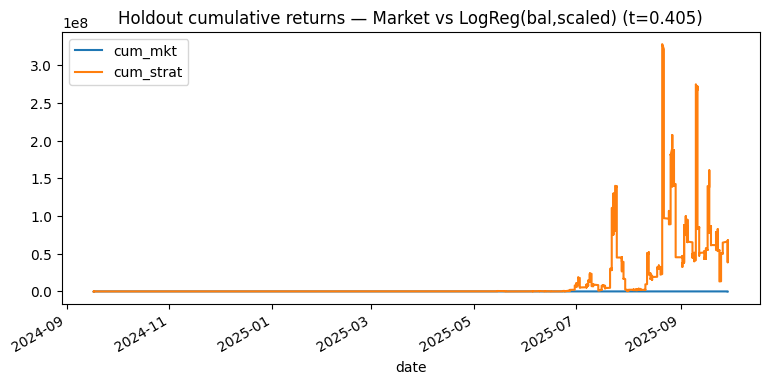

In [ ]:

# (LogReg + RF + XGB, with SPY feature)

!pip -q install xgboost

import numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 0) Add SPY daily return as market context
df_feat["date"] = pd.to_datetime(df_feat["date"])

spy = yf.download("SPY",
                  start=str(df_feat["date"].min().date()),
                  end=str(df_feat["date"].max().date()),
                  interval="1d", auto_adjust=True)

# Flatten possible multi-index
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = [c[0] if isinstance(c, tuple) else c for c in spy.columns]

spy = spy[["Close"]].reset_index().rename(columns={"Close":"spy_close"})
spy["date"] = pd.to_datetime(spy["Date"]) if "Date" in spy.columns else spy["date"]
spy["spy_ret_1d"] = spy["spy_close"].pct_change()
spy = spy[["date","spy_ret_1d"]]

df_feat = df_feat.merge(spy, on="date", how="left")
feature_cols = list(feature_cols) + ["spy_ret_1d"]
df_feat = df_feat.dropna(subset=feature_cols + ["y"])

# 1) Train/test split
df_feat = df_feat.sort_values(["date","ticker"]).reset_index(drop=True)
cut = int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
X_train, y_train = train[feature_cols].values, train["y"].values
X_test,  y_test  = test[feature_cols].values,  test["y"].values

# 2) Define models
models = {}

pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
models["LogReg(bal,scaled)"] = pipe_log

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    min_samples_leaf=5,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
models["RandomForest(bal)"] = rf

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
models["XGBoost"] = xgb

# 3) Fit and predict probabilities
probas = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    probas[name] = model.predict_proba(X_test)[:,1]

# 4) Threshold tuning
mid = len(X_test)//2
y_val, y_hold = y_test[:mid], y_test[mid:]
probas_val = {k:v[:mid] for k,v in probas.items()}
probas_hold= {k:v[mid:] for k,v in probas.items()}

def tune_threshold(proba_val, y_val, grid=np.linspace(0.4,0.6,41)):
    best_t, best_f1 = 0.5, -1
    for t in grid:
        f1 = f1_score(y_val, (proba_val >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t

def eval_model(name, proba_hold, y_hold, t):
    pred = (proba_hold >= t).astype(int)
    acc = accuracy_score(y_hold, pred)
    auc = roc_auc_score(y_hold, proba_hold)
    p   = precision_score(y_hold, pred, zero_division=0)
    r   = recall_score(y_hold, pred, zero_division=0)
    f1  = f1_score(y_hold, pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_hold, pred, labels=[0,1]).ravel()
    return dict(Model=name, ACC=acc, AUC=auc, P=p, R=r, F1=f1, TP=tp, FP=fp, TN=tn, FN=fn, Thresh=t)

results = []
for name, proba_val in probas_val.items():
    t = tune_threshold(proba_val, y_val)
    results.append(eval_model(name, probas_hold[name], y_hold, t))

# 5) Baselines
always_up   = np.ones_like(y_hold)
always_down = np.zeros_like(y_hold)

def eval_fixed(name, pred, y_true):
    acc = accuracy_score(y_true, pred)
    auc = 0.5
    p   = precision_score(y_true, pred, zero_division=0)
    r   = recall_score(y_true, pred, zero_division=0)
    f1  = f1_score(y_true, pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, pred, labels=[0,1]).ravel()
    return dict(Model=name, ACC=acc, AUC=auc, P=p, R=r, F1=f1, TP=tp, FP=fp, TN=tn, FN=fn, Thresh=None)

results.append(eval_fixed("Always Up",   always_up,   y_hold))
results.append(eval_fixed("Always Down", always_down, y_hold))

summary = pd.DataFrame(results).sort_values(["AUC","ACC","F1"], ascending=False)
pd.set_option("display.precision", 4)
print(summary.to_string(index=False))

#6) Plot cumulative returns for best model
best = summary.iloc[0]["Model"]
t_best = summary.iloc[0]["Thresh"]
proba_best = probas_hold[best] if best in probas_hold else None

if proba_best is not None:
    hold = test.iloc[mid:].copy()
    hold["proba_up"] = proba_best
    hold["signal"]   = (hold["proba_up"] >= t_best).astype(int)
    hold["mkt_ret"]  = hold["next_ret_1d"].fillna(0.0)
    hold["strat_ret"]= hold["mkt_ret"] * (2*hold["signal"]-1)
    hold["cum_mkt"]  = (1 + hold["mkt_ret"]).cumprod()
    hold["cum_strat"]= (1 + hold["strat_ret"]).cumprod()
    hold.set_index("date")[["cum_mkt","cum_strat"]].plot(figsize=(9,4),
        title=f"Holdout cumulative returns — Market vs {best} (t={t_best:.3f})")
    plt.show()


In [ ]:
# Save processed dataset for reuse
cols_out = ["date","ticker","open","high","low","close","volume"] + feature_cols + ["y"]
df_feat[cols_out].to_csv("stock_daily_features.csv", index=False)
print("Saved stock_daily_features.csv")


Saved stock_daily_features.csv


In [ ]:
!pip -q install huggingface_hub skops

from huggingface_hub import notebook_login
notebook_login()   # Will pop up a widget in Colab; paste your token once


In [ ]:
# PUSH BEST MODEL TO HUGGING FACE
!pip -q install huggingface_hub skops

import os, skops.io as sio
from huggingface_hub import HfApi, create_repo

api = HfApi()


username = api.whoami()["name"]
print("Logged in as:", username)

# Build repo ID
HF_REPO_NAME = "stock-sentiment-daily-v1"
HF_REPO_ID   = f"{username}/{HF_REPO_NAME}"
print("Pushing to:", HF_REPO_ID)

# Pick best model from summary
best_row  = summary.iloc[0]
best_name = best_row["Model"]
if   "LogReg" in best_name: best_model = models["LogReg(bal,scaled)"]
elif "RandomForest" in best_name: best_model = models["RandomForest(bal)"]
elif "XGBoost" in best_name: best_model = models["XGBoost"]
else: raise ValueError(f"Unexpected best model: {best_name}")

# Serialize artifacts
os.makedirs("hf_model", exist_ok=True)
sio.dump({"model": best_model, "feature_cols": list(feature_cols)}, "hf_model/model.skops")

# Minimal README
with open("hf_model/README.md","w") as f:
    f.write(f"# {best_name} — Stock Daily Sentiment\n"
            f"ACC={best_row['ACC']:.4f}, AUC={best_row['AUC']:.4f}, F1={best_row['F1']:.4f}\n")

# Create repo if not exists
create_repo(repo_id=HF_REPO_ID, repo_type="model", private=True, exist_ok=True)

# Upload files
api.upload_file(
    path_or_fileobj="hf_model/model.skops",
    path_in_repo="model.skops",
    repo_id=HF_REPO_ID,
    repo_type="model",
)

api.upload_file(
    path_or_fileobj="hf_model/README.md",
    path_in_repo="README.md",
    repo_id=HF_REPO_ID,
    repo_type="model",
)

print(f"✅ Uploaded to https://huggingface.co/{HF_REPO_ID}")


Logged in as: jacobre20
Pushing to: jacobre20/stock-sentiment-daily-v1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/hf_api.py:9717: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


✅ Uploaded to https://huggingface.co/jacobre20/stock-sentiment-daily-v1
